In [53]:
cd './drive/My Drive/AI VIET NAM/Tensorflow/Generatives/NeuralStyleTransfer'

[Errno 2] No such file or directory: './drive/My Drive/AI VIET NAM/Tensorflow/Generatives/NeuralStyleTransfer'
/content/drive/My Drive/AI VIET NAM/Tensorflow/Generatives/NeuralStyleTransfer


In [54]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import imutils
from scipy.stats import pearsonr
import sys
import scipy 
from imutils import build_montages

In [55]:
import numpy as np
from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors

In [56]:
import cv2 
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import PIL
import numpy as np

**Download Image**

In [57]:
#content_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [58]:
content_path = "./images/123057.jpg"
#style_path = "./images/test_style_image.jpg"

In [59]:
content_name = 123057
style_id = 1

In [60]:
content_image = cv2.imread(content_path)
style_image = cv2.imread(style_path)

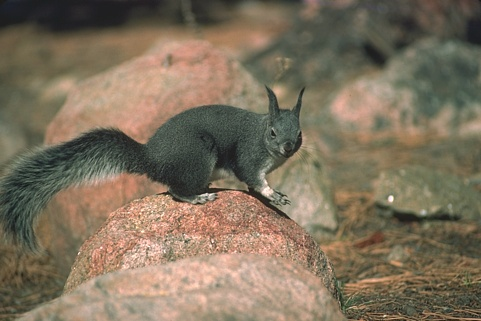

In [61]:
cv2_imshow(content_image)

In [62]:
content_image.shape

(321, 481, 3)

**Preprocessing Image**

In [63]:
style_image = imutils.resize(style_image, width=content_image.shape[1], height=content_image.shape[0])


In [64]:
#content_image = imutils.resize(content_image, width=512)

In [65]:
content_image = content_image/255
style_image = style_image/255

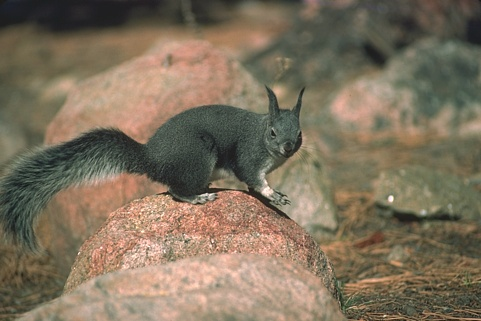

In [66]:
cv2_imshow(content_image*255)

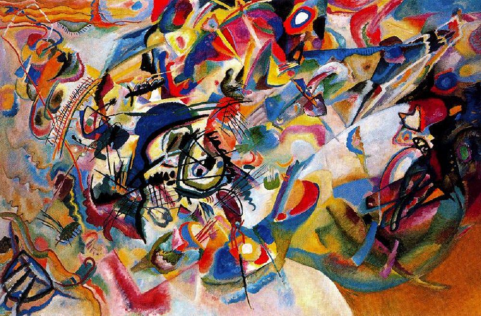

In [67]:
cv2_imshow(style_image*255)

In [68]:
content_image = tf.cast(content_image, dtype=tf.float32)
style_image = tf.cast(style_image, dtype=tf.float32)

In [69]:
content_image = tf.expand_dims(content_image, axis=0)
style_image = tf.expand_dims(style_image, axis=0)

In [70]:
content_layers = ['block5_conv2']
style_layers = ["block1_conv1",'block2_conv1','block3_conv1',"block4_conv1","block5_conv1"]

In [272]:
syn_layers = ["block4_conv1"]

**Define Correlation Matrix**

In [273]:
def gram_matrix(input_tensor):
  # np.random.seed(0)
  # b,h,w,c = input_tensor.shape
  # input_tensor = tf.reshape(input_tensor, (b,-1,c))
  # input_tensor = input_tensor.numpy()[0]
  # np.take(input_tensor,np.random.permutation(input_tensor.shape[1]),axis=1,out=input_tensor)
  # input_tensor = tf.reshape(input_tensor, (b,h,w,c))
  
  temp = tf.linalg.einsum("bijc, bijd -> bcd", input_tensor, input_tensor)
  shape = tf.shape(input_tensor)
  num_locations = tf.cast(shape[1] * shape[2], tf.float32)
  return temp / num_locations

In [274]:
def pearsonr_matrix(input_tensor):
  input_shape = input_tensor.shape
  mean = []
  std = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      mean.append(tf.math.reduce_mean(input_tensor[i,:,:,j]))
      std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = ((input_tensor - mean)/(std))
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)


  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result
  

In [275]:
def cov_matrix(input_tensor):
  input_shape = input_tensor.shape
  mean = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      mean.append(tf.math.reduce_mean(input_tensor[i,:,:,j]))
      #std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = (input_tensor - mean)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result/num_locations

In [276]:
def chebyshev_matrix(input_tensor):
  b,h,w,c = input_tensor.shape
  feature_map = tf.reshape(input_tensor,(b,-1,c))     
  G = tf.linalg.einsum('bic, bid->bicd', feature_map, feature_map)
  D = tf.reshape(tf.linalg.diag_part(G),(b,h*w,c,1))+ tf.transpose(tf.reshape(tf.linalg.diag_part(G),(b,-1,c,1)),perm=(0,1,3,2))-2*G 
  D = tf.sqrt(D+tf.constant(4e0, dtype=tf.float32, shape=(b,h*w,c,c)))
  result = np.max(D, axis=1)
  return result

In [277]:
def euclidean_matrix(input_tensor):
  b,h,w,c = input_tensor.shape
  feature_map = tf.reshape(input_tensor,(b,-1,c))     
  G = tf.einsum('bic, bid->bcd', feature_map, feature_map)
  D = tf.reshape(tf.linalg.diag_part(G),(b,-1,1))+ tf.transpose(tf.reshape(tf.linalg.diag_part(G),(b,-1,1)),perm=(0,2,1)) - 2*G
  result = tf.sqrt(D)
  
  result = tf.reshape(result, [b,c,c])
  return result


In [278]:
def cosine_sim(input_tensor):
  input_shape = input_tensor.shape
  norm = []
  for i in range(input_shape[0]):
    for j in range(input_shape[3]):
      norm.append(tf.norm(input_tensor[i,:,:,j]) + 1e-8 )
      #std.append(tf.math.reduce_std(input_tensor[i,:,:,j]) + 1e-8)
  temp = (input_tensor/norm)
  result = tf.linalg.einsum("bijc,bijd -> bcd", temp, temp)
  return result


**Load Backbone**


In [279]:
def vgg_layers(layer_names):
  vgg = VGG19(include_top=False, weights="imagenet")
  vgg.trainable= False
  outputs = [vgg.get_layer(name).output for name in layer_names]

  return Model([vgg.input], outputs)


**Image Synthesis Model**
The model help us visalize the learned style of an image in VGG layers 


In [280]:
class ImageSynthesis(tf.keras.models.Model):
  def __init__(self, syn_layers):
    super(ImageSynthesis, self).__init__()
    self.VGG = vgg_layers(syn_layers)
    self.syn_layers = syn_layers
    self.num_syn_layers = len(syn_layers)
  def call(self, inputs, matrix_method):
    inputs = inputs * 255.0
    inputs = keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.VGG(inputs)
    syn_outputs = outputs[:self.num_syn_layers]
    if len(syn_outputs) == 1:
      syn_outputs = tf.expand_dims(syn_outputs, axis=0)
    syn_outputs = [matrix_method(syn_out) for syn_out in syn_outputs]
    syn_dict = {syn_name : value for syn_name, value in zip(self.syn_layers, syn_outputs)}
    return {'synthesis':syn_dict}

In [281]:
def synthesis_loss(output):
  syn_features = output['synthesis']
  syn_loss= tf.add_n([tf.reduce_mean((syn_features[name] - texture_targets[name])**2) for name in syn_layers])
 
  syn_loss *= syn_weights/num_syn_layers
  return syn_loss

**Style Transfer Model**

In [282]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.VGG = vgg_layers(style_layers+content_layers)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.content_layers = content_layers
    self.num_content_layers = len(content_layers)

  def call (self, inputs, matrix_method):
    inputs= inputs * 255.0
    inputs = keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.VGG(inputs)
    content_outputs = outputs[self.num_style_layers:]
    style_outputs = outputs[:self.num_style_layers]
    # if len(style_outputs) == 1:
    #   style_outputs = tf.expand_dims(style_outputs, axis=0)
    style_outputs = [matrix_method(style_out) for style_out in style_outputs]
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = { style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

In [283]:
def style_content_loss(output):
  content_features = output['content']
  style_features = output['style']

  style_loss= tf.add_n([tf.reduce_mean((style_features[name] - style_targets[name])**2) for name in style_layers])
 
  style_loss *= style_weights/num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_features[name] - content_targets[name])**2) for name in content_layers])
  content_loss *= content_weights/num_content_layers
  loss = style_loss + content_loss
  return loss

In [284]:
def clip_0_1(inputs):
  return tf.clip_by_value(inputs, clip_value_min=0, clip_value_max=1)
  

In [285]:

def train_step(image,losses, grads, matrix_method):

  with tf.GradientTape() as tape:
    outputs = extractor(image,matrix_method)
    
    loss = style_content_loss(outputs)
    losses.append(loss)
  
  grad = tape.gradient(loss, image)
  grads.append(grad)
 
  opt.apply_gradients([(grad, image)])
  
  image.assign(clip_0_1(image))
  
  


In [286]:
def syn_step(image, losses, matrix_method):
  with tf.GradientTape() as tape:
    outputs = syn_extractor(image, matrix_method)
    loss = synthesis_loss(outputs)
    losses.append(loss)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [287]:
image = tf.Variable(content_image)
style_weights = 1e-2
content_weights = 1e4
num_style_layers = len(style_layers)
num_content_layers= len(content_layers)

In [288]:
syn_weights = 1e-2
num_syn_layers = len(syn_layers)

In [289]:
extractor = StyleContentModel(style_layers, content_layers)

In [290]:
syn_extractor = ImageSynthesis(syn_layers)

In [291]:
opt = keras.optimizers.Adam(0.02, beta_1=0.99, epsilon=0.1)

Runing with dot product

In [292]:
style_targets = extractor(style_image, gram_matrix)['style']
content_targets = extractor(content_image, gram_matrix)['content']

// Traing Style Transfer

In [51]:
import time

start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
result_images = []
further_images = []
result_images.append(content_image.numpy()[0]*255.0)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, gram_matrix)
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  copy = image
  further_images.append(copy)
  path = "./outputs/gramMatrix/style"+str(style_id)+'_content'+str(content_name)+'_gramMatrix'+"_iteration"+ str(step_per_epoch*(e+1)) +".png"
  cv2.imwrite(path, image.numpy()[0]*255.0)
  result_images.append(image.numpy()[0]*255.0)


result_images = np.array(result_images)
vis = build_montages(result_images, (128,128),(10,1))[0]
cv2_imshow(vis)
path = "./outputs/GramMAtrix/"+str(content_name)+".png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")

N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/gramMatrix/"+ str(content_name) +"_loss.png")



KeyboardInterrupt: ignored

// Get Style image from generated output

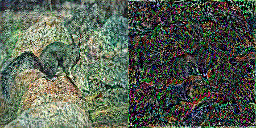

[INFO] Total Time: 86.74839639663696


In [226]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100

path ="/content/drive/MyDrive/AI VIET NAM/Tensorflow/Generatives/NeuralStyleTransfer/outputs/CosineSimilarity/style1_content123057_CosineSimilarity_iteration1000.png"
result = cv2.imread(path)
result = result/255.0
result = tf.cast(result, dtype=tf.float32)
result = tf.expand_dims(result,axis=0)
random_ = tf.random.uniform(shape=result.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
#result = np.expand_dims(result, axis=0)
  
texture_targets = syn_extractor(result, gram_matrix)['synthesis']
result_syn = []
result_syn.append(result.numpy()[0]*255.0)
for e in range(epochs):
    for i in range(step_per_epoch):
      
        syn_step(input_noise, losses, gram_matrix)
      #print(image)
    #cv2_imshow(input_noise.numpy()[0]*255.0)
    result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/gramMatrix/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)





// Get style of the input style image

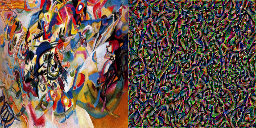

True

In [293]:
texture_targets = syn_extractor(style_image, gram_matrix)['synthesis']
random_ = tf.random.uniform(shape=style_image.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
result_syn = []
result_syn.append(style_image.numpy()[0]*255.0)
losses= []
epochs = 10
step_per_epoch = 100
for e in range(epochs):
  for i in range(step_per_epoch):
      
    syn_step(input_noise, losses, gram_matrix)
    #print(image)
  #cv2_imshow(input_noise.numpy()[0]*255.0)
  result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/gramMatrix/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

Run with Pearsons's r correlation

In [ ]:
style_targets = extractor(style_image, pearsonr_matrix)['style']
content_targets = extractor(content_image, pearsonr_matrix)['content']

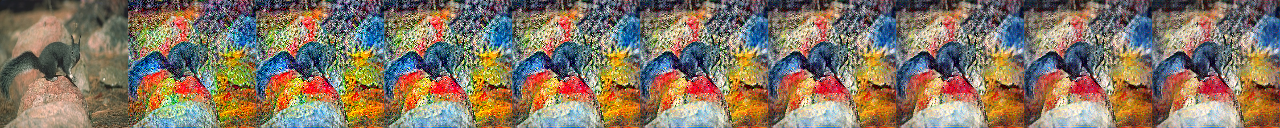

[INFO] Total Time: 3003.15069937706


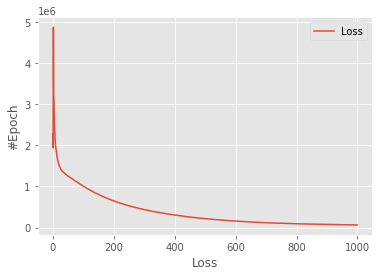

In [ ]:
import time

start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
result_images = []
further_images = []
result_images.append(content_image.numpy()[0]*255.0)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, pearsonr_matrix)
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  copy = image
  further_images.append(copy)
  path = "./outputs/Pearson/style"+str(style_id)+'_content'+str(content_name)+'_Pearson'+"_iteration"+ str(step_per_epoch*(e+1)) +".png"
  cv2.imwrite(path, image.numpy()[0]*255.0)
  result_images.append(image.numpy()[0]*255.0)


result_images = np.array(result_images)
vis = build_montages(result_images, (128,128),(10,1))[0]
cv2_imshow(vis)
path = "./outputs/Pearson/"+str(content_name)+".png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")

N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/Pearson/"+ str(content_name) +"_loss.png")



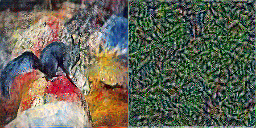

[INFO] Total Time: 99.95776295661926


In [ ]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100

result = result_images[-1]
result = result/255.0
result = tf.cast(result, dtype=tf.float32)
result = tf.expand_dims(result,axis=0)
random_ = tf.random.uniform(shape=result.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
#result = np.expand_dims(result, axis=0)
  
texture_targets = syn_extractor(result, gram_matrix)['synthesis']
result_syn = []
result_syn.append(result.numpy()[0]*255.0)
for e in range(epochs):
    for i in range(step_per_epoch):
      
        syn_step(input_noise, losses, gram_matrix)
      #print(image)
    #cv2_imshow(input_noise.numpy()[0]*255.0)
    result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/Pearson/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)





In [ ]:
grad = np.array(grads[-1]).reshape(-1)
plt.hist(grad,bins=128)

Run with covarriance 

In [ ]:
style_targets = extractor(style_image, cov_matrix)['style']
content_targets = extractor(content_image, cov_matrix)['content']

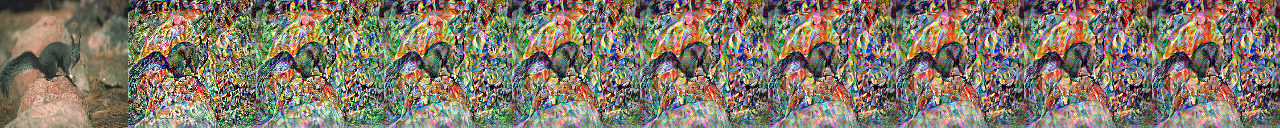

[INFO] Total Time: 873.7005739212036


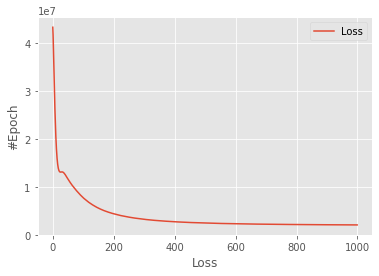

In [ ]:
import time

start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
result_images = []
further_images = []
result_images.append(content_image.numpy()[0]*255.0)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, cov_matrix)
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  copy = image
  further_images.append(copy)
  path = "./outputs/Covariance/style"+str(style_id)+'_content'+str(content_name)+'_Covariance'+"_iteration"+ str(step_per_epoch*(e+1)) +".png"
  cv2.imwrite(path, image.numpy()[0]*255.0)
  result_images.append(image.numpy()[0]*255.0)


result_images = np.array(result_images)
vis = build_montages(result_images, (128,128),(10,1))[0]
cv2_imshow(vis)
path = "./outputs/Covariance/"+str(content_name)+".png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")

N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/Covariance/"+ str(content_name) +"_loss.png")



In [ ]:
grad = np.array(grads[-1]).reshape(-1)
plt.hist(grad,bins=128)

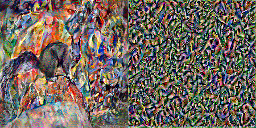

[INFO] Total Time: 100.16708874702454


In [ ]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100

result = result_images[-1]
result = result/255.0
result = tf.cast(result, dtype=tf.float32)
result = tf.expand_dims(result,axis=0)
random_ = tf.random.uniform(shape=result.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
#result = np.expand_dims(result, axis=0)
  
texture_targets = syn_extractor(result, gram_matrix)['synthesis']
result_syn = []
result_syn.append(result.numpy()[0]*255.0)
for e in range(epochs):
    for i in range(step_per_epoch):
      
        syn_step(input_noise, losses, gram_matrix)
      #print(image)
    #cv2_imshow(input_noise.numpy()[0]*255.0)
    result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/Covariance/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)





Run with chebychev


In [ ]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, cov_matrix)
    #print(image)
  cv2_imshow(image.numpy()[0]*255.0)
  path = "./Covariance/epoch{}.png".format(e)
  cv2.imwrite(path, image.numpy()[0]*255.0)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")
N = np.arange(1000)
plt.plot(N,losses, label='Loss')

plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./Covariance/loss.png")

Run with Euclidean

In [ ]:
style_targets = extractor(style_image, euclidean_matrix)['style']
content_targets = extractor(content_image, euclidean_matrix)['content']

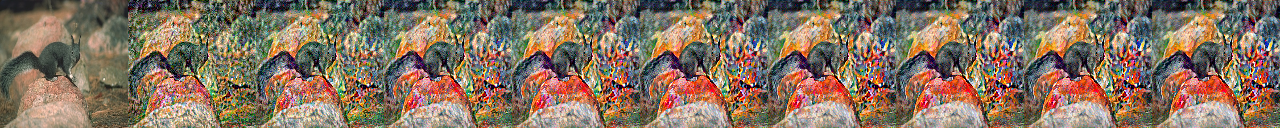

[INFO] Total Time: 107.20267462730408


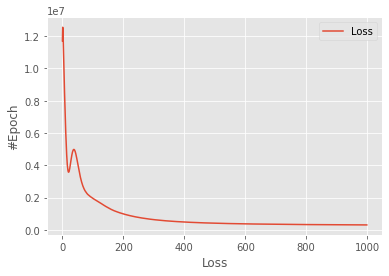

In [ ]:
import time

start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
result_images = []
further_images = []
result_images.append(content_image.numpy()[0]*255.0)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, euclidean_matrix)
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  copy = image
  further_images.append(copy)
  path = "./outputs/Euclidean/style"+str(style_id)+'_content'+str(content_name)+'_Euclidean'+"_iteration"+ str(step_per_epoch*(e+1)) +".png"
  cv2.imwrite(path, image.numpy()[0]*255.0)
  result_images.append(image.numpy()[0]*255.0)


result_images = np.array(result_images)
vis = build_montages(result_images, (128,128),(10,1))[0]
cv2_imshow(vis)
path = "./outputs/Euclidean/"+str(content_name)+".png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")

N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/Euclidean/"+ str(content_name) +"_loss.png")



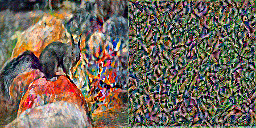

[INFO] Total Time: 100.2085313796997


In [ ]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100

result = result_images[-1]
result = result/255.0
result = tf.cast(result, dtype=tf.float32)
result = tf.expand_dims(result,axis=0)
random_ = tf.random.uniform(shape=result.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
#result = np.expand_dims(result, axis=0)
  
texture_targets = syn_extractor(result, gram_matrix)['synthesis']
result_syn = []
result_syn.append(result.numpy()[0]*255.0)
for e in range(epochs):
    for i in range(step_per_epoch):
      
        syn_step(input_noise, losses, gram_matrix)
      #print(image)
    #cv2_imshow(input_noise.numpy()[0]*255.0)
    result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/Euclidean/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)





(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        0.0000e+00, 4.0000e+00, 6.0000e+00, 2.0000e+00, 1.1000e+01,
        3.0000e+00, 7.0000e+00, 6.0000e+00, 7.0000e+00, 1.0000e+01,
        1.1000e+01, 1.7000e+01, 1.6000e+01, 2.6000e+01, 2.2000e+01,
        3.6000e+01, 3.8000e+01, 4.4000e+01, 6.1000e+01, 7.4000e+01,
        9.6000e+01, 1.0700e+02, 1.2800e+02, 1.8400e+02, 2.5200e+02,
        3.3100e+02, 4.3200e+02, 5.5900e+02, 8.0600e+02, 1.1340e+03,
        1.7250e+03, 2.5760e+03, 4.1330e+03, 6.3290e+03, 1.0270e+04,
        1.7806e+04, 3.1821e+04, 5.8812e+04, 9.3857e+04, 9.3038e+04,
        5.8194e+04, 3.2349e+04, 1.8110e+04, 1.0484e+04, 6.4710e+03,
        4.0330e+03, 2.6220e+03, 1.7040e+03, 1.1810e+03, 8.4100e+02,
        6.1000e+02, 4.3300e+02, 3.3700e+02, 2.1900e+02, 1.8200e+02,
        1.3800e+02, 9.4000e+01, 8.0000e+01, 5.80

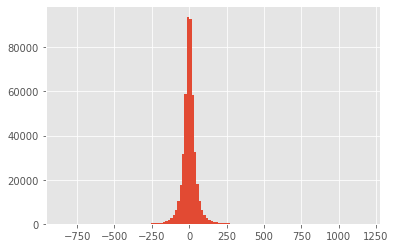

In [ ]:
grad = np.array(grads[-1]).reshape(-1)
plt.hist(grad,bins=128)

Run with cosine sim

In [ ]:
style_targets = extractor(style_image, cosine_sim)['style']
content_targets = extractor(content_image, cosine_sim)['content']

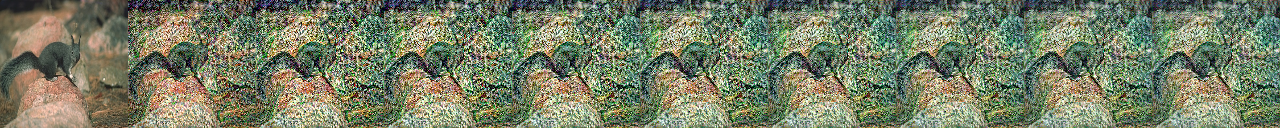

[INFO] Total Time: 1282.0439355373383


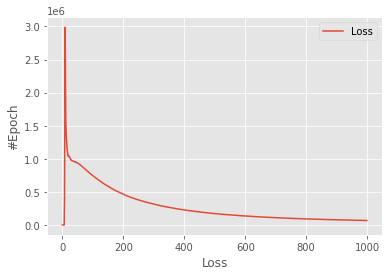

In [ ]:
import time

start = time.time()
epochs = 10
step_per_epoch = 100
losses = []
grads = []
image = tf.Variable(content_image)
result_images = []
further_images = []
result_images.append(content_image.numpy()[0]*255.0)
for e in range(epochs):
  for i in range(step_per_epoch):
    
    train_step(image, losses, grads, cosine_sim)
    #print(image)
  #cv2_imshow(image.numpy()[0]*255.0)
  copy = image
  further_images.append(copy)
  path = "./outputs/CosineSimilarity/style"+str(style_id)+'_content'+str(content_name)+'_CosineSimilarity'+"_iteration"+ str(step_per_epoch*(e+1)) +".png"
  cv2.imwrite(path, image.numpy()[0]*255.0)
  result_images.append(image.numpy()[0]*255.0)


result_images = np.array(result_images)
vis = build_montages(result_images, (128,128),(10,1))[0]
cv2_imshow(vis)
path = "./outputs/CosineSimilarity/"+str(content_name)+".png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)

plt.style.use("ggplot")

N = np.arange(1000)
plt.plot(N,losses, label='Loss')
plt.xlabel("Loss")
plt.ylabel("#Epoch")
plt.legend()
plt.savefig("./outputs/CosineSimilarity/"+ str(content_name) +"_loss.png")



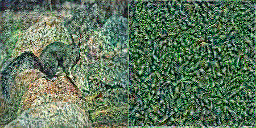

[INFO] Total Time: 100.07870125770569


In [ ]:
import time
start = time.time()
epochs = 10
step_per_epoch = 100

result = result_images[-1]
result = result/255.0
result = tf.cast(result, dtype=tf.float32)
result = tf.expand_dims(result,axis=0)
random_ = tf.random.uniform(shape=result.shape, minval=0, maxval=0.2)
input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)
#result = np.expand_dims(result, axis=0)
  
texture_targets = syn_extractor(result, gram_matrix)['synthesis']
result_syn = []
result_syn.append(result.numpy()[0]*255.0)
for e in range(epochs):
    for i in range(step_per_epoch):
      
        syn_step(input_noise, losses, gram_matrix)
      #print(image)
    #cv2_imshow(input_noise.numpy()[0]*255.0)
    result_syn.append(input_noise.numpy()[0]*255.0)

result_syn = np.array([result_syn[0], result_syn[1]])
vis = build_montages(result_syn, (128,128),(2,1))[0]
cv2_imshow(vis)
path = "./outputs/CosineSimilarity/Dot_function_syn_conv1_0_output1.png"
cv2.imwrite(path, vis)

end = time.time()

print("[INFO] Total Time:", end-start)





In [ ]:
grad = np.array(grads[-1]).reshape(-1)
plt.hist(grad,bins=128)


In [ ]:
a = np.ones((1,2))

In [ ]:
a

In [ ]:
a*a.T